In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
device = torch.device("mps")

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)

3.6%

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%
33.8%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%
100.0%

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets)
print(example_data.shape)

tensor([3, 9, 4, 9, 9, 0, 8, 3, 1, 2, 3, 9, 1, 3, 6, 6, 4, 4, 9, 7, 3, 7, 6, 3,
        4, 8, 4, 6, 8, 6, 1, 1, 1, 1, 0, 0, 1, 8, 4, 0, 1, 2, 7, 9, 3, 2, 3, 8,
        3, 2, 0, 4, 6, 6, 5, 5, 3, 0, 3, 7, 2, 4, 1, 6, 7, 5, 4, 1, 0, 8, 5, 9,
        0, 9, 6, 1, 8, 0, 9, 3, 5, 7, 8, 5, 6, 4, 2, 2, 2, 1, 8, 4, 4, 2, 1, 5,
        9, 3, 7, 0, 4, 1, 7, 2, 2, 6, 5, 1, 2, 6, 1, 3, 1, 2, 7, 4, 1, 3, 2, 9,
        3, 7, 2, 7, 4, 7, 0, 0, 9, 0, 9, 5, 1, 6, 9, 8, 1, 4, 6, 7, 5, 5, 6, 4,
        5, 4, 0, 7, 4, 1, 3, 8, 2, 6, 2, 2, 8, 4, 1, 9, 6, 7, 5, 0, 7, 4, 6, 2,
        6, 8, 7, 9, 8, 0, 7, 4, 2, 4, 9, 0, 4, 6, 5, 6, 6, 4, 4, 8, 3, 8, 0, 9,
        5, 6, 3, 3, 8, 4, 4, 6, 7, 8, 5, 3, 4, 3, 3, 3, 3, 1, 8, 8, 9, 1, 0, 1,
        4, 1, 0, 2, 0, 6, 5, 1, 5, 8, 8, 1, 3, 9, 4, 5, 9, 2, 5, 6, 5, 8, 2, 7,
        4, 1, 6, 8, 7, 9, 3, 3, 4, 4, 5, 4, 9, 8, 2, 9, 1, 6, 7, 1, 0, 5, 1, 9,
        2, 1, 5, 2, 7, 9, 0, 0, 6, 0, 8, 7, 2, 6, 1, 7, 6, 1, 2, 1, 6, 3, 1, 4,
        1, 7, 5, 9, 3, 8, 6, 3, 8, 7, 4,

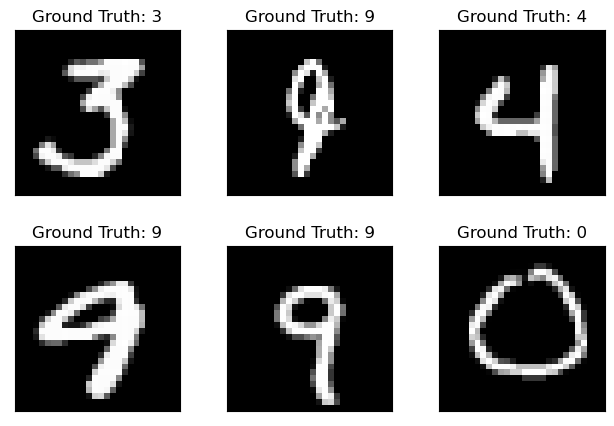

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [7]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './model.pth')
      torch.save(optimizer.state_dict(), './optimizer.pth')
          
train(1)

/var/folders/jr/tf9k36ws1956sfj0w8ybnj2m0000gn/T/ipykernel_49498/800033116.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303384
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.279412
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.289252
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.262080
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.253610
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.227270
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.195740
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.184438
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.071461
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.949601
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.779031
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.790707
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.765616
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.678705
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.477044
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.439807
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.124465
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.139860
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.357752
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.921102
Train Epoch: 1 [12800/60000 (

In [8]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
test()

/var/folders/jr/tf9k36ws1956sfj0w8ybnj2m0000gn/T/ipykernel_49498/800033116.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/Users/jiayingli/miniforge3/envs/torch-gpu/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1864, Accuracy: 9445/10000 (94%)



/var/folders/jr/tf9k36ws1956sfj0w8ybnj2m0000gn/T/ipykernel_49498/800033116.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.0778, Accuracy: 9760/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.202973
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.223977
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.132205
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.355577
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.235190
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.270044
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.254363
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.279710
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.253607
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.265410
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.224728
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.169349
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.277386
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.209034
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.256125
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.244494
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.288826
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.234944
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.168626
Train Epoch: 1 [12160

ValueError: x and y must be the same size

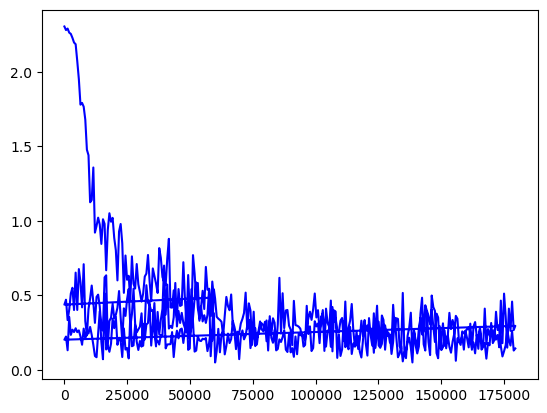

In [10]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()